<a href="https://colab.research.google.com/github/itspritish/Abstractive-Summarization-With-Transfer-Learning/blob/master/ulmfit_stackO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.text import *
import pandas as pd
import numpy as np

In [0]:
!nvidia-smi

Fri Aug 16 10:44:54 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    16W /  70W |     10MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!wget https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv
df = pd.read_csv('stack-overflow-data.csv')
print('Length of dataset: '+str(len(df.index)))
df.head()

--2019-08-16 10:45:48--  https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44319561 (42M) [text/csv]
Saving to: ‘stack-overflow-data.csv’

stack-overflow-data 100%[===================>]  42.27M   123MB/s    in 0.3s    

2019-08-16 10:45:49 (123 MB/s) - ‘stack-overflow-data.csv’ saved [44319561/44319561]

Length of dataset: 40000


,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python


In [0]:
unq_tags = df['tags'].unique().tolist()
#filter any mention of the tags present in the text
df['post'] = df['post'].apply(lambda x: " ".join([word for word in x.split() if word not in unq_tags]))

In [0]:
unq_tags

['c#',
 'asp.net',
 'objective-c',
 '.net',
 'python',
 'angularjs',
 'iphone',
 'ruby-on-rails',
 'ios',
 'c',
 'sql',
 'java',
 'jquery',
 'css',
 'c++',
 'php',
 'android',
 'mysql',
 'javascript',
 'html']

In [0]:
df['post'].head(3)

0    what is causing this behavior in our datetime ...
1    have dynamic load as if it was in an iframe i ...
2    how to convert a float value in to min:sec i m...
Name: post, dtype: object

In [0]:
from sklearn.model_selection import train_test_split

df_trn, df_val = train_test_split(df, stratify = df['tags'], test_size = 0.2)

df_trn.shape, df_val.shape

((32000, 2), (8000, 2))

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", text_cols='post', label_cols='tags')

# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm.train_ds.vocab, bs=32,
                                     text_cols='post', label_cols='tags')

In [0]:
data_clas.show_batch()

text,target
xxbos error in program how to solve below error ... fatal error c1083 : can not open include file : xxunk : no such file or directory is there a alternative for xxunk file below is the code : / / xxunk : defines the entry point for the console application . / / < pre><code > # include stdafx.h # include xxunk # include xxunk # include stdlib.h #,c++
xxbos dropdown submenu in sidebar doesn t drop so i m trying to create a sidebar that has a dropdown submenu and it s been three days and i still can t tell what is creating the xxunk in my dropdown submenu . can someone be so kind to correct my code ( sorry it s a mess . my brain is currently like that atm . ) the problem,css
xxbos links in ie have strange behavior at the top of my web page i have some text links formatted by css . in chrome and firefox they behave properly ; in ie when each link is clicked the formatting changes and the text links get slightly larger ; moving the links over to the right . if you click a few links the last link gets bumped down to,css
xxbos how to make button visible i have made a button by default invisible by customizing code . but now my problem is i ca nt make the button visible ! the thing i want is that when user log in means the log out button should be visible . how can i do it using netbeans can any1 help me i m new in gui . what condition should,java
xxbos trying to validate the form in angular js i was trying to validate fields of a form in but it shows the error - message with out clicking the button . i can t figure out what is the problem in my code . when i click on button i will display the error message but the problem is its shows error message on page load my code is,angularjs


In [0]:
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 5.25E-02


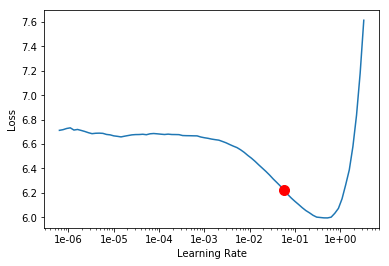

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [0]:
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.283496,3.862122,0.363712,10:34
1,3.861714,3.450600,0.398892,10:39


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.213615,3.118051,0.439212,12:03
1,3.044077,2.949927,0.462213,12:02
2,2.824342,2.864485,0.473670,12:03
3,2.669567,2.850125,0.476952,12:02


In [0]:
learn.predict("How to debug in", n_words=6)

TypeError: ignored

In [0]:
learn.save_encoder('ft_enc')

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (32000 items)
x: TextList
xxbos is xxunk equal to -1 in cpp definitions < pre><code > int fdstring : : xxunk fdstring & & searchstring int rend ) const { return xxunk ) rend = = npos string::npos : rend ) ; } < / code > < / pre > here i have defined < pre><code > ifdef unicode # define string std::wstring # else # define string std::string # endif < / code > < / pre > i am sure std::string::npos is defined in cpp reference as -1 but in wstring i am not sure if its explicitly defined as -1 so can i assume xxunk is also -1,xxbos devise error messages i have the problem with devise : devise works well but in devise / registration / new.html.erb i have the next string < pre><code><%= devise_error_messages ! % > < / code > < / pre > that string forms error msg like - > < pre><code><div id= error_explanation > < xxunk errors prohibited this user from being saved : < / h2 > < ul > < li > email has already been taken < / li > < li > password

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 2.51E-02


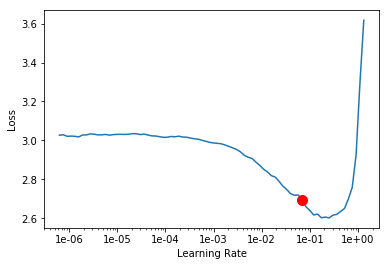

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [0]:
learn.fit_one_cycle(4, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.550991,1.409898,0.567375,03:05
1,1.426139,1.702663,0.582750,03:02
2,1.317522,1.066740,0.639250,03:05
3,1.074878,1.045977,0.661250,03:06


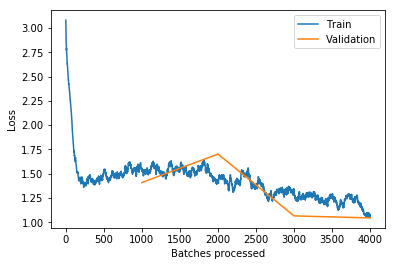

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(5e-3, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.129282,1.294093,0.679625,03:33
1,1.094504,0.865217,0.709375,03:33
2,1.004256,0.805289,0.720625,03:33
3,0.834177,0.792957,0.725750,03:34


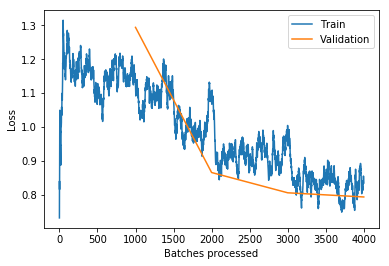

In [0]:
learn.recorder.plot_losses()

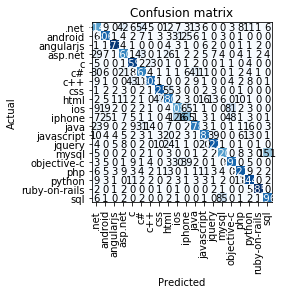

In [0]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

In [0]:
interp.most_confused()

[('mysql', 'sql', 151),
 ('iphone', 'ios', 126),
 ('sql', 'mysql', 85),
 ('ios', 'objective-c', 81),
 ('ios', 'iphone', 65),
 ('css', 'html', 55),
 ('.net', 'c#', 54),
 ('iphone', 'objective-c', 48),
 ('html', 'css', 47),
 ('asp.net', 'c#', 43),
 ('c++', 'c', 43),
 ('.net', 'asp.net', 42),
 ('c#', 'java', 41),
 ('javascript', 'jquery', 39),
 ('objective-c', 'iphone', 39),
 ('android', 'ios', 31),
 ('java', 'c#', 31),
 ('c#', '.net', 30),
 ('objective-c', 'ios', 30),
 ('asp.net', '.net', 29),
 ('asp.net', 'html', 26),
 ('android', 'iphone', 25),
 ('iphone', 'android', 25),
 ('jquery', 'html', 24),
 ('c', 'c++', 23),
 ('java', '.net', 23),
 ('c#', 'asp.net', 21),
 ('javascript', 'html', 20),
 ('jquery', 'javascript', 20),
 ('ios', 'android', 19),
 ('html', 'javascript', 16),
 ('java', 'python', 16),
 ('java', 'c++', 14),
 ('.net', 'java', 13),
 ('html', 'jquery', 13),
 ('javascript', 'python', 13),
 ('php', 'html', 13),
 ('.net', 'html', 12),
 ('.net', 'python', 11),
 ('c#', 'javascript'

In [0]:
learn.predict("Given a string as input, in main method print all its permutations in sorted order.")

(Category java,
 tensor(11),
 tensor([0.1098, 0.0518, 0.0084, 0.0601, 0.0914, 0.1938, 0.0201, 0.0010, 0.0127,
         0.0061, 0.0061, 0.2237, 0.0468, 0.0180, 0.0048, 0.0035, 0.0474, 0.0850,
         0.0052, 0.0044]))

In [0]:
learn.export()